<a href="https://colab.research.google.com/github/abrarelidrisi/MRI-Segmentation/blob/main/Trial_3_5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

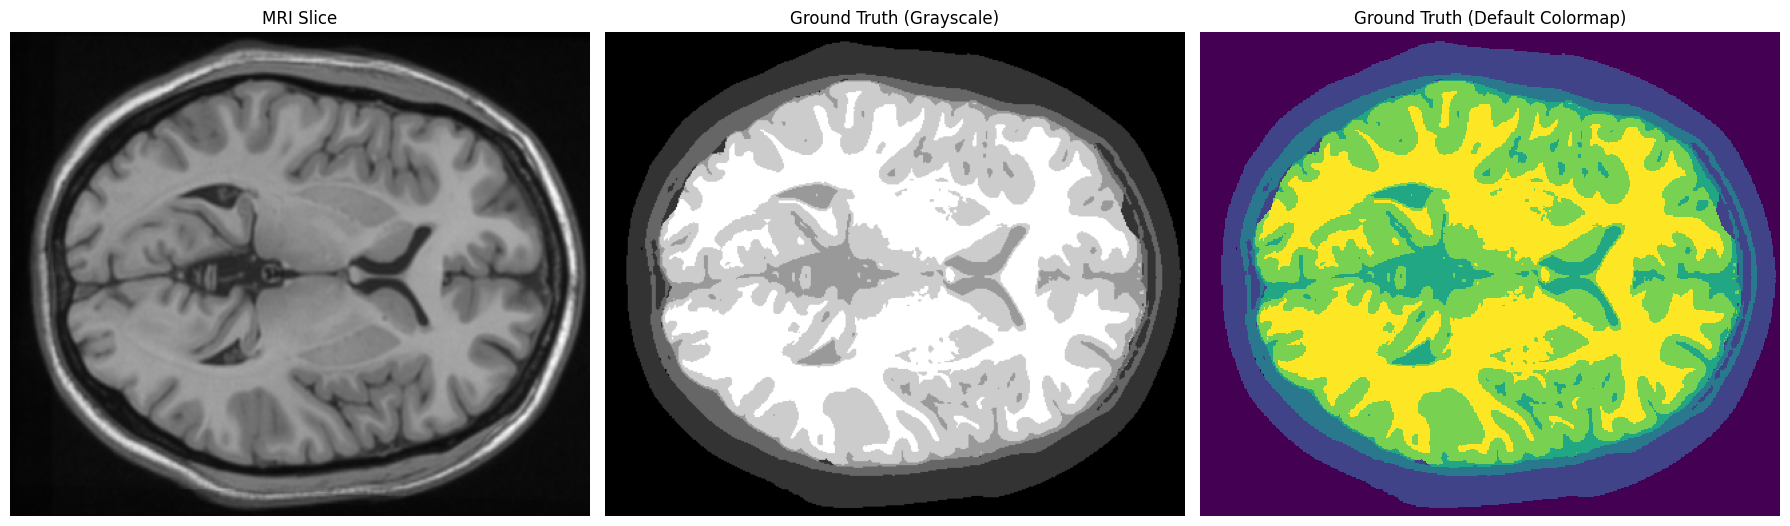

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.io import loadmat
import sys

# Load data
data = loadmat('Brain.mat')
T1 = data['T1']
label = data['label']
import matplotlib.pyplot as plt

# Select a single slice (e.g., the first slice)
slice_data = T1[..., 0]
ground_truth = label[..., 0]

# Creating a figure with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Display the MRI slice (grayscale)
ax[0].imshow(slice_data, cmap='gray')
ax[0].set_title("MRI Slice")
ax[0].axis('off')  # Turn off axis for cleaner display

# Display the ground truth as-is (grayscale)
ax[1].imshow(ground_truth, cmap='gray')
ax[1].set_title("Ground Truth (Grayscale)")
ax[1].axis('off')

# Display the ground truth with the default colormap
ax[2].imshow(ground_truth, interpolation='none', vmin=0, vmax=5)  # Default colormap
ax[2].set_title("Ground Truth (Default Colormap)")
ax[2].axis('off')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

In [2]:
# Inspect the range of pixel intensities in the slice
print(f"Slice intensity range: Min = {np.min(slice_data)}, Max = {np.max(slice_data)}")
print(f"Ground truth range: Min = {np.min(ground_truth)}, Max = {np.max(ground_truth)}")

# Check unique labels in the ground truth
unique_labels = np.unique(ground_truth)
print(f"Unique labels in the ground truth: {unique_labels}")

Slice intensity range: Min = 958.6986694335938, Max = 491434.28125
Ground truth range: Min = 0, Max = 5
Unique labels in the ground truth: [0 1 2 3 4 5]


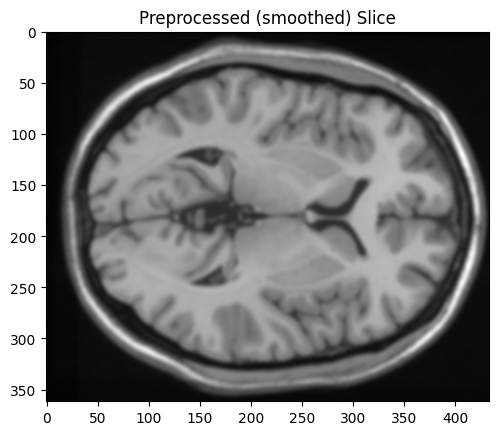

In [3]:
# Normalize the slice
slice_normalized = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))

# Apply Gaussian smoothing
slice_smoothed = cv2.GaussianBlur(slice_normalized, (5, 5), 5)

# Visualize the preprocessed slice
plt.imshow(slice_smoothed, cmap='gray')
plt.title("Preprocessed (smoothed) Slice")
plt.show()


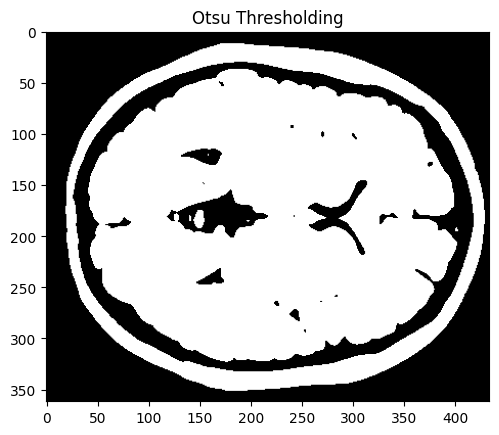

In [4]:
# Apply Otsu's thresholding
_, thresholded = cv2.threshold((slice_smoothed * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Visualize thresholded result
plt.imshow(thresholded, cmap='gray')
plt.title("Otsu Thresholding")
plt.show()
#This allows us to segment our image into two global categories using Otsu. Specifically, the background (air which is label 0) and the foreground (the tissue, which we can later segment it further).

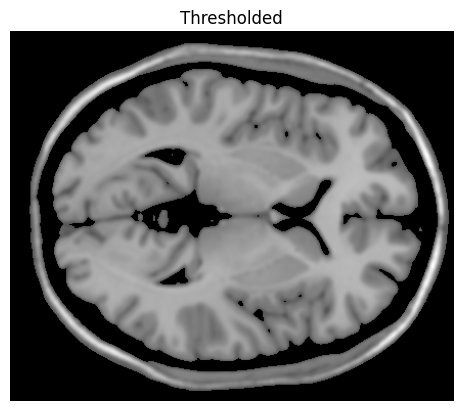

In [32]:
thresholded_img = thresholded * slice_smoothed
plt.imshow(thesholded_img, cmap='gray')
plt.axis('off')
plt.title('Thresholded')
plt.show()

In [54]:
#Define k-means segmentation so we can apply it to the image
from sklearn.cluster import KMeans

def kmeans_segmentation(image, n_clusters=6):
    # Reshape the image to a 2D array
    X = image.reshape(-1, 1)

    # Fit KMeans to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)

    # Predict the labels for the data
    labels = kmeans.fit_predict(X)

    # Reshape the labels to the original image shape
    labels = labels.reshape(image.shape)

    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_

    # Order the centroids and return the indices
    order = np.argsort(centroids, axis=0)

    return labels, order

cluster_labels, order = kmeans_segmentation(thresholded_img, n_clusters=6)

In [55]:
temporal_masks = {}
temporal_masks["0"] = (cluster_labels == order[0]).astype(int)
temporal_masks["1"] = (cluster_labels == order[1]).astype(int)
temporal_masks["2"] = (cluster_labels == order[2]).astype(int)
temporal_masks["3"] = (cluster_labels == order[3]).astype(int)
temporal_masks["4"] = (cluster_labels == order[4]).astype(int)
temporal_masks["5"] = (cluster_labels == order[5]).astype(int)

In [56]:
def plot_masks(temporal_masks, rows=1, cols=2, slice_id = None):

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

    fig.suptitle('Temporal Masks')

    flatten_axes = axes.flat
    for ax, (key, mask) in zip(flatten_axes, temporal_masks.items()):
        if slice_id is not None:
            mask = mask[:,:,slice_id]
        ax.imshow(mask, cmap='gray')
        ax.set_title(f'Mask: {key}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def temporal_masks2final_segmented_mask(temporal_masks, labels = range(6), slice_id = None):
    if slice_id is not None:
        segmented_labels = np.zeros_like(temporal_masks["0"][:,:,0])
    else:
        segmented_labels = np.zeros_like(temporal_masks["0"])

    # Accumulate all the temporal masks in the segmented_labels
    for label in labels:
        mask = temporal_masks[str(label)]
        if slice_id is not None:
            mask = mask[:,:,slice_id]
        segmented_labels[mask == 1] = label

    return segmented_labels

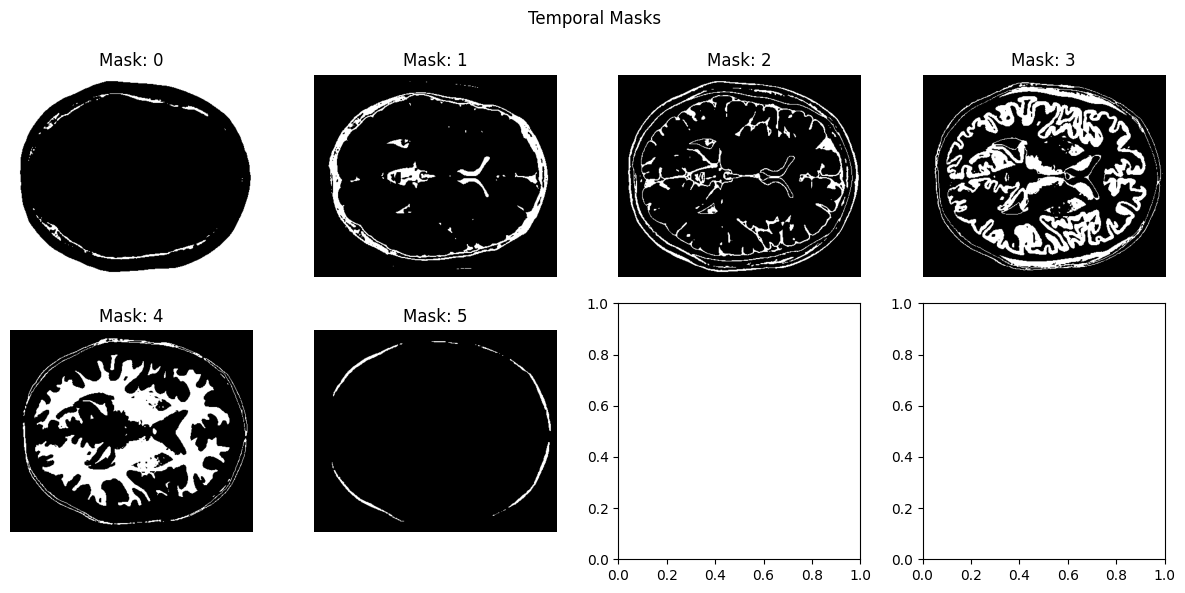

In [48]:
plot_masks(temporal_masks, rows=2, cols=4)

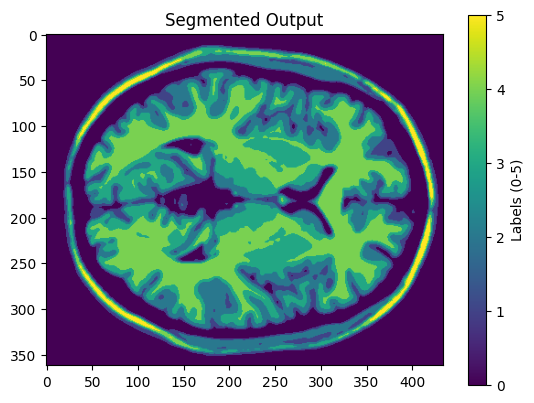

In [57]:
segmented_img = temporal_masks2final_segmented_mask(temporal_masks)

# Plot the final segmented image
plt.imshow(segmented_img)
plt.title('Segmented Output')
plt.colorbar(ticks=range(6), label="Labels (0-5)")
plt.show()

In [58]:
def dice_coefficient(pred, truth):
    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format
    intersection = np.sum(pred * truth)
    return 2 * intersection / (np.sum(pred) + np.sum(truth))

dice_score = dice_coefficient(segmented_img, ground_truth)
print(f"Dice Coefficient: {dice_score:.3f}")

Dice Coefficient: 0.892


In [59]:
def jaccard_index(pred, truth):
    pred = pred > 0
    truth = truth > 0
    intersection = np.sum(pred * truth)
    union = np.sum(pred + truth) - intersection
    return intersection / union
jaccard_score = jaccard_index(segmented_img, ground_truth)
print(f"Jaccard Index: {jaccard_score:.3f}")

Jaccard Index: 4.120


In [60]:
def pixel_accuracy(pred, truth):

    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format

    correct = np.sum(pred == truth)  # Count matching pixels
    total = truth.size  # Total number of pixels
    return correct / total

accuracy_score = pixel_accuracy(segmented_img, ground_truth)
print(f"Pixel Accuracy: {accuracy_score:.3f}")

Pixel Accuracy: 0.856


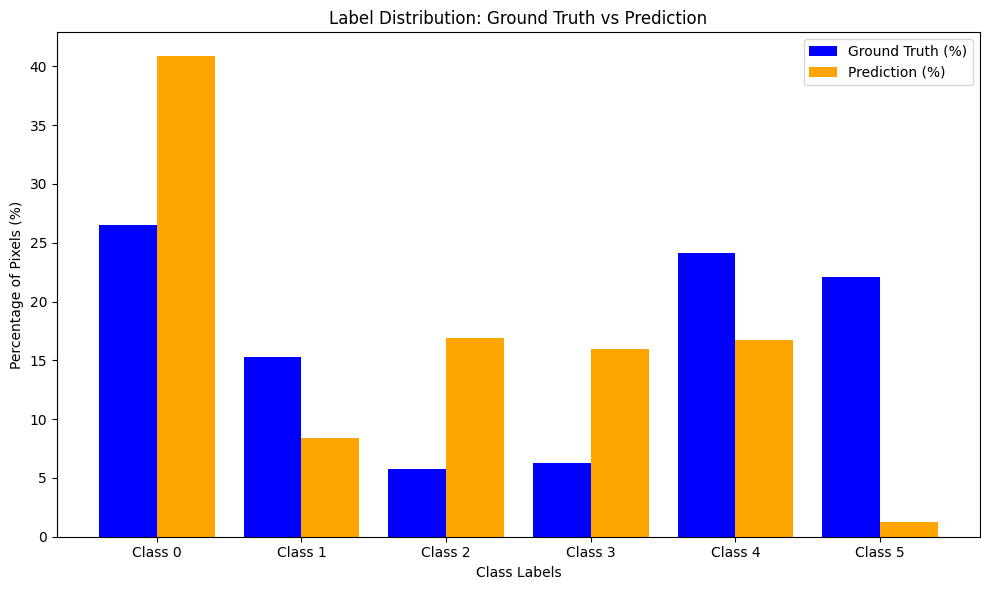

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def compare_label_distributions(ground_truth, prediction, num_classes):
    """
    Compare label distributions between ground truth and prediction.

    Args:
    - ground_truth: 2D array of ground truth labels.
    - prediction: 2D array of predicted labels.
    - num_classes: Number of unique classes in the labels.
    """
    # Count label occurrences in ground truth
    gt_labels, gt_counts = np.unique(ground_truth, return_counts=True)
    gt_distribution = np.zeros(num_classes)
    gt_distribution[gt_labels] = gt_counts

    # Count label occurrences in prediction
    pred_labels, pred_counts = np.unique(prediction, return_counts=True)
    pred_distribution = np.zeros(num_classes)
    pred_distribution[pred_labels] = pred_counts

    # Normalize to percentage if needed
    gt_percentage = (gt_distribution / np.sum(gt_distribution)) * 100
    pred_percentage = (pred_distribution / np.sum(pred_distribution)) * 100

    # Plot the distributions
    labels = [f"Class {i}" for i in range(num_classes)]
    x = np.arange(num_classes)

    plt.figure(figsize=(10, 6))

    # Bar plot
    plt.bar(x - 0.2, gt_percentage, width=0.4, label='Ground Truth (%)', color='blue')
    plt.bar(x + 0.2, pred_percentage, width=0.4, label='Prediction (%)', color='orange')

    # Add labels, legend, and title
    plt.xticks(x, labels)
    plt.xlabel("Class Labels")
    plt.ylabel("Percentage of Pixels (%)")
    plt.title("Label Distribution: Ground Truth vs Prediction")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
num_classes = 6  # Number of classes in your dataset
compare_label_distributions(ground_truth, segmented_img, num_classes)